## Data Preparation and Analysis

Missing values in General Dataset:
DATE                          0
GENERAL_DAM_OCCUPANCY_RATE    0
GENERAL_DAM_RESERVED_WATER    0
dtype: int64


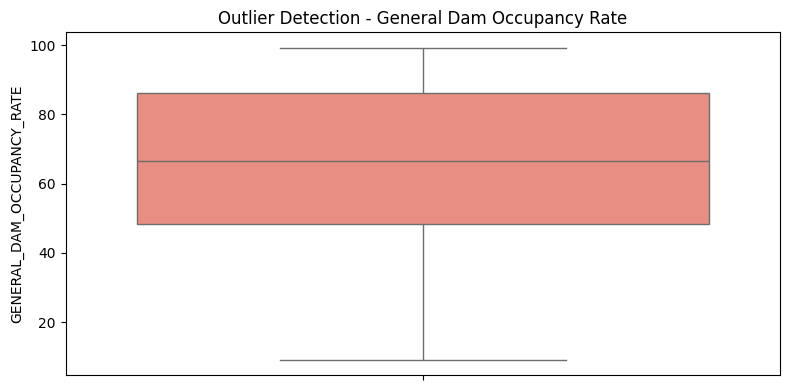

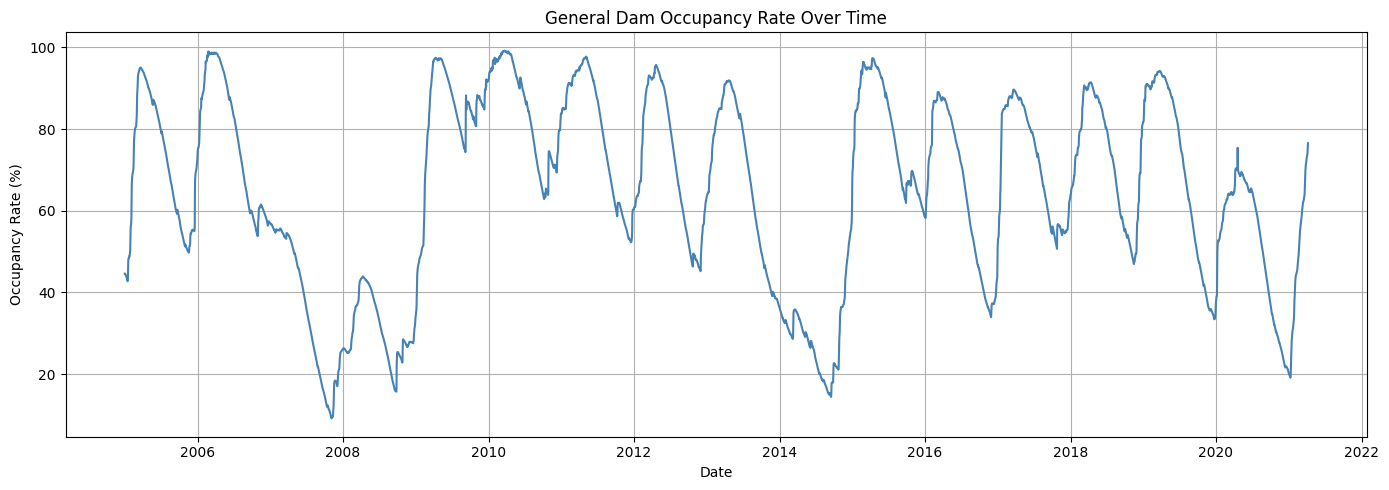


Missing values in Dam-Specific Dataset:
Tarih           0
Omerli          0
Darlik          0
Elmali          0
Terkos          0
Alibey          0
Buyukcekmece    0
Sazlidere       0
Kazandere       0
Pabucdere       0
Istrancalar     0
dtype: int64


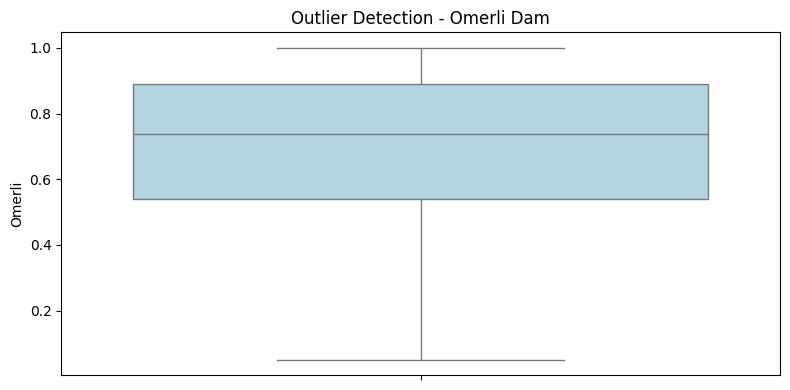

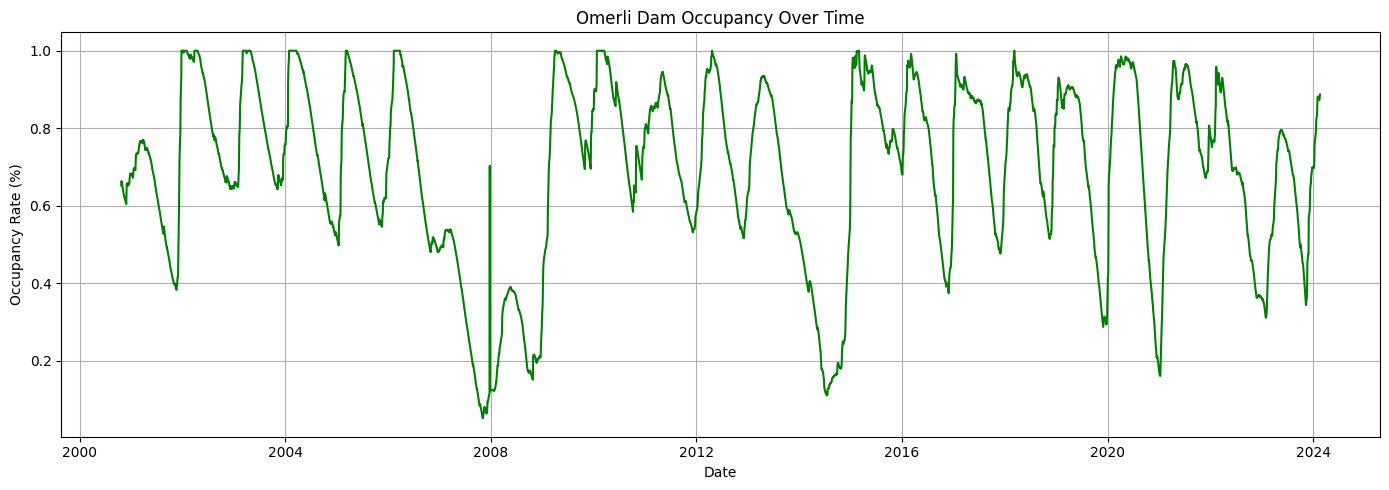

In [16]:
#  Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

# Suppressing warnings for clean output
warnings.filterwarnings('ignore')

# ==============================
#  GENERAL DATASET CLEANING
# ==============================

df_general = pd.read_csv("../data/raw/dam_occupancy.csv")

# Converting date
df_general['DATE'] = pd.to_datetime(df_general['DATE'], format='%Y-%m-%d')
df_general.sort_values('DATE', inplace=True)
df_general.reset_index(drop=True, inplace=True)

# Checking missing values
print("Missing values in General Dataset:")
print(df_general.isnull().sum())

# Interpolating missing values
df_general['GENERAL_DAM_OCCUPANCY_RATE'] = df_general['GENERAL_DAM_OCCUPANCY_RATE'].interpolate(method='linear')
df_general['GENERAL_DAM_RESERVED_WATER'] = df_general['GENERAL_DAM_RESERVED_WATER'].interpolate(method='linear')

# Duplicate date check and resolve
df_general = df_general.groupby('DATE', as_index=False).mean()

# Create complete date range
full_range = pd.date_range(start=df_general['DATE'].min(), end=df_general['DATE'].max(), freq='D')
df_general = df_general.set_index('DATE').reindex(full_range).rename_axis('DATE').reset_index()

# Interpolating again if needed
df_general['GENERAL_DAM_OCCUPANCY_RATE'] = df_general['GENERAL_DAM_OCCUPANCY_RATE'].interpolate(method='linear')
df_general['GENERAL_DAM_RESERVED_WATER'] = df_general['GENERAL_DAM_RESERVED_WATER'].interpolate(method='linear')

# Outlier detection for occupancy
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='salmon')
plt.title("Outlier Detection - General Dam Occupancy Rate")
plt.tight_layout()
plt.show()

# Time series plot
plt.figure(figsize=(14, 5))
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], label="General Occupancy", color='steelblue')
plt.title("General Dam Occupancy Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()



# Save cleaned general dataset
df_general.to_csv("../data/processed/dam_occupancy_cleaned.csv", index=False)


# ==============================
#  DAM-SPECIFIC DATASET CLEANING
# ==============================

df_dams = pd.read_excel("../data/raw/istanbul-dams-daily-occupancy-rates.xlsx")

# Rename columns to fix corrupted characters
correct_columns = ['Tarih', 'Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey',
                   'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
df_dams.columns = correct_columns

# Convert and sort
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'], dayfirst=True)
df_dams.sort_values('Tarih', inplace=True)
df_dams.reset_index(drop=True, inplace=True)

# Checking missing values
print("\nMissing values in Dam-Specific Dataset:")
print(df_dams.isnull().sum())

# Group and reindex to full date range
df_dams = df_dams.groupby('Tarih', as_index=False).mean()
full_range_dams = pd.date_range(start=df_dams['Tarih'].min(), end=df_dams['Tarih'].max(), freq='D')
df_dams = df_dams.set_index('Tarih').reindex(full_range_dams).rename_axis('Tarih').reset_index()

# Forward-fill missing values
df_dams.fillna(method='ffill', inplace=True)

# Outlier detection for one sample dam (e.g., Omerli)
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_dams['Omerli'], color='lightblue')
plt.title("Outlier Detection - Omerli Dam")
plt.tight_layout()
plt.show()

# Plot time series for one dam
plt.figure(figsize=(14, 5))
plt.plot(df_dams['Tarih'], df_dams['Omerli'], label='Omerli Dam', color='green')
plt.title("Omerli Dam Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()



# Save cleaned dam-specific dataset
df_dams.to_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv", index=False)

## Sentetik Veri Ekleme

In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

# --- 1. Veri Yükleme ve Temizleme ---
file_path = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv"
df = pd.read_csv(file_path)
df['Tarih'] = pd.to_datetime(df['Tarih'])

# Eksik değerleri temizle (ffill veya interpolate)
# Temizlenmiş dosyadan geldiği için çok az olmalı ama yine de emin olalım
df.ffill(inplace=True)
df.bfill(inplace=True) # Baştaki NaNs için

df = df.set_index('Tarih')

# Doluluk oranı sütunlarını al
dam_columns = df.columns.tolist()

# Hedef bitiş tarihi
end_date_forecast = pd.to_datetime('2025-07-01')

print(f"Original data ends on: {df.index.max()}")
print(f"Target forecast end date: {end_date_forecast}")

# Kaç gün tahmin edeceğimizi hesapla
# Son gün + 1'den hedef bitiş tarihine kadar olan günler
forecast_periods = (end_date_forecast - df.index.max()).days +1 # Son gün de dahil


print(f"Number of days to forecast: {forecast_periods}")

# Sentetik verileri depolamak için bir DataFrame
synthetic_df = pd.DataFrame(index=pd.date_range(df.index.max() + pd.Timedelta(days=1), end_date_forecast))

# --- 2. Her Baraj İçin Prophet ile Sentetik Veri Oluşturma ---
print("\nGenerating synthetic data for each dam using Prophet...")

for dam_col in dam_columns:
    print(f"  - Processing {dam_col}...")
    
    # Prophet'in beklediği 'ds' ve 'y' formatına dönüştür
    dam_df_prophet = df[[dam_col]].reset_index()
    dam_df_prophet.columns = ['ds', 'y']
    
    # Prophet modelini oluştur ve eğit
    # Mevsimselliği ayarlayabiliriz (yıllık, haftalık)
    # yearly_seasonality=True: Yıllık mevsimselliği yakala
    # weekly_seasonality=True: Haftalık mevsimselliği yakala (su tüketiminde önemli olabilir)
    # daily_seasonality=True: Günlük mevsimselliği yakala (eğer varsa)
    model = Prophet(
        yearly_seasonality=True, 
        weekly_seasonality=True, # Genellikle doluluklarda veya tüketimde hafta içi/hafta sonu farklılığı olabilir
        daily_seasonality=False # Genellikle bu tür verilerde günlük mevsimsellik çok belirgin değildir
    )
    
    # Artırıcılar (regressors) eklemek isterseniz burada ekleyebilirsiniz (örn. yağış, tüketim)
    # Ancak bu veri setinde o bilgiler yok, bu yüzden model dolaylı olarak öğrenecek.

    model.fit(dam_df_prophet)
    
    # Gelecek için tarih çerçevesi oluştur
    future = model.make_future_dataframe(periods=forecast_periods)
    
    # Tahmin yap
    forecast = model.predict(future)
    
    # Sadece sentetik kısmını al ve DataFrame'e ekle
    synthetic_series = forecast[['ds', 'yhat']].set_index('ds')['yhat'].loc[synthetic_df.index]
    synthetic_df[dam_col] = synthetic_series

    # Opsiyonel: Tahminleri görselleştir (kontrol için)
    # fig = model.plot(forecast)
    # plt.title(f"Prophet Forecast for {dam_col}")
    # plt.show()
    # fig2 = model.plot_components(forecast)
    # plt.title(f"Prophet Components for {dam_col}")
    # plt.show()


# --- 3. Orijinal Veri ile Sentetik Veriyi Birleştirme ---
# Orijinal df'in son 60 gününü alıp, üzerine sentetik veriyi ekleyerek geçişi daha pürüzsüz yapabiliriz.
# Ancak şimdilik sadece doğrudan birleştirme yapalım.
# Yani, df.index.max() tarihinden sonraki tüm sentetik veriyi kullanacağız.

# Orijinal veriye sentetik veriyi ekle
# pd.concat, indeksleri çakışmadığı için direkt ekleyecektir.
final_df = pd.concat([df, synthetic_df])

# İndeksi yeniden sırala ve sıfırla (tarih sırasına göre)
final_df = final_df.sort_index().reset_index()
final_df.rename(columns={'index': 'Tarih'}, inplace=True) # 'index' ismini 'Tarih' yap

print(f"\nFinal DataFrame starts on: {final_df['Tarih'].min()}")
print(f"Final DataFrame ends on: {final_df['Tarih'].max()}")
print(f"Final DataFrame shape: {final_df.shape}")




# --- 4. Yeni Veri Setini Kaydetme ---
# Yeni bir dosya olarak kaydedelim, orijinalini değiştirmeyelim
output_file_path = "../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv"
final_df.to_csv(output_file_path, index=False)
print(f"\nSynthetic data added and saved to: {output_file_path}")






Original data ends on: 2024-02-19 00:00:00
Target forecast end date: 2025-07-01 00:00:00
Number of days to forecast: 499

Generating synthetic data for each dam using Prophet...
  - Processing Omerli...


23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Darlik...


23:32:53 - cmdstanpy - INFO - Chain [1] start processing
23:32:56 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Elmali...


23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:59 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Terkos...


23:33:01 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Alibey...


23:33:05 - cmdstanpy - INFO - Chain [1] start processing
23:33:07 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Buyukcekmece...


23:33:08 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Sazlidere...


23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:14 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Kazandere...


23:33:16 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Pabucdere...


23:33:19 - cmdstanpy - INFO - Chain [1] start processing
23:33:21 - cmdstanpy - INFO - Chain [1] done processing


  - Processing Istrancalar...


23:33:22 - cmdstanpy - INFO - Chain [1] start processing
23:33:23 - cmdstanpy - INFO - Chain [1] done processing



Final DataFrame starts on: 2000-10-23 00:00:00
Final DataFrame ends on: 2025-07-01 00:00:00
Final DataFrame shape: (9018, 11)

Synthetic data added and saved to: ../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv


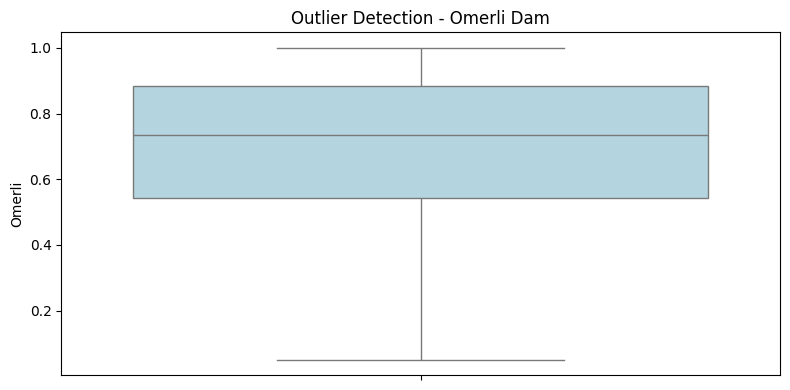

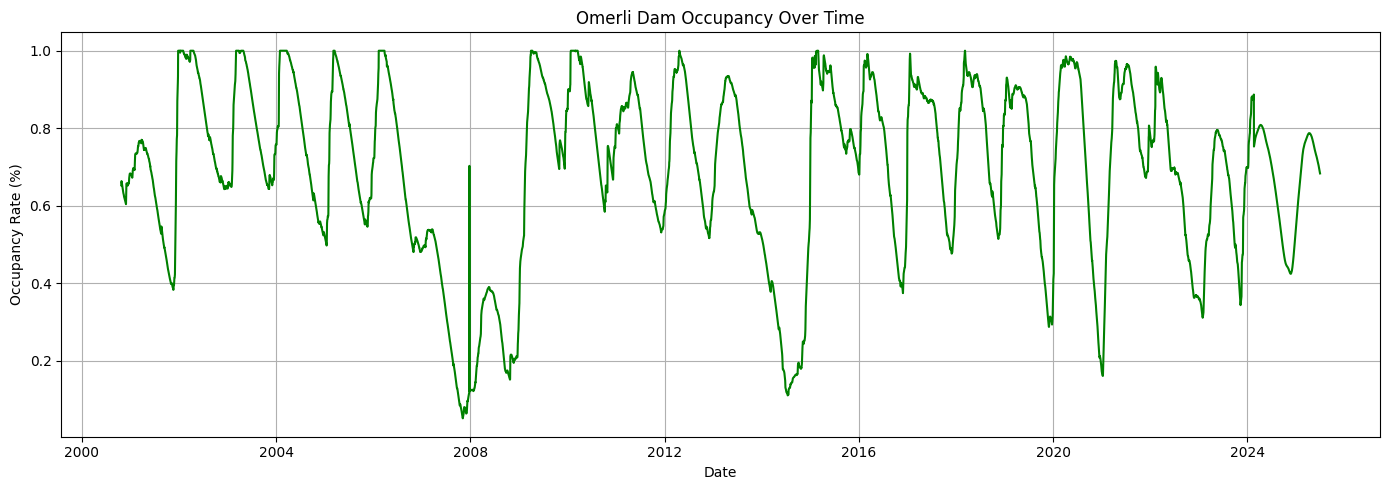

In [26]:
# Outlier detection for one sample dam (e.g., Omerli)
plt.figure(figsize=(8, 4))
sns.boxplot(data=final_df['Omerli'], color='lightblue')
plt.title("Outlier Detection - Omerli Dam")
plt.tight_layout()
plt.show()

# Plot time series for one dam
plt.figure(figsize=(14, 5))
plt.plot(final_df['Tarih'], final_df['Omerli'], label='Omerli Dam', color='green')
plt.title("Omerli Dam Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Yağış için sentetik veri ekleme

Original rainfall data ends on: 2024-02-18 00:00:00
Target forecast end date: 2025-07-01 00:00:00
Number of days to forecast rainfall/consumption: 500

Generating synthetic consumption data using Prophet...


23:56:58 - cmdstanpy - INFO - Chain [1] start processing
23:56:58 - cmdstanpy - INFO - Chain [1] done processing


  - Consumption data generated successfully.


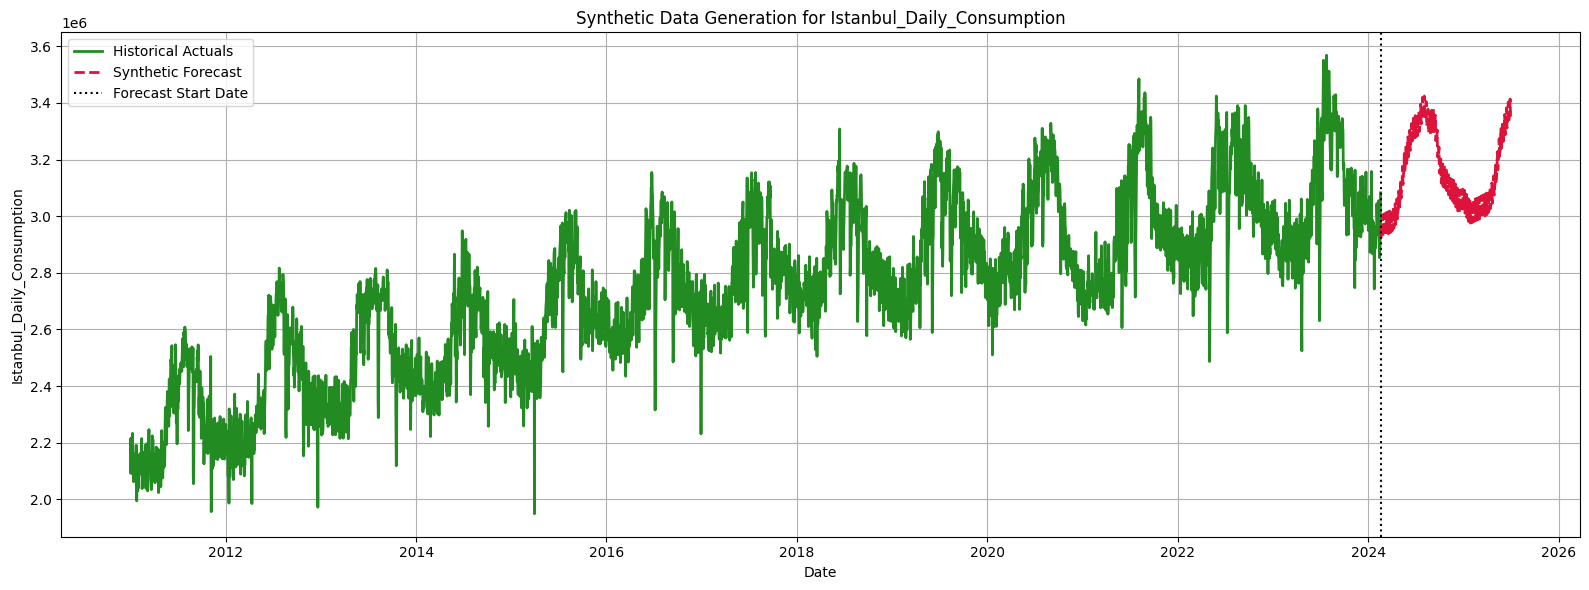


Generating synthetic rainfall data (improved method)...

--- Plotting Synthetic Rainfall Data Generation Results (Sample Columns) ---


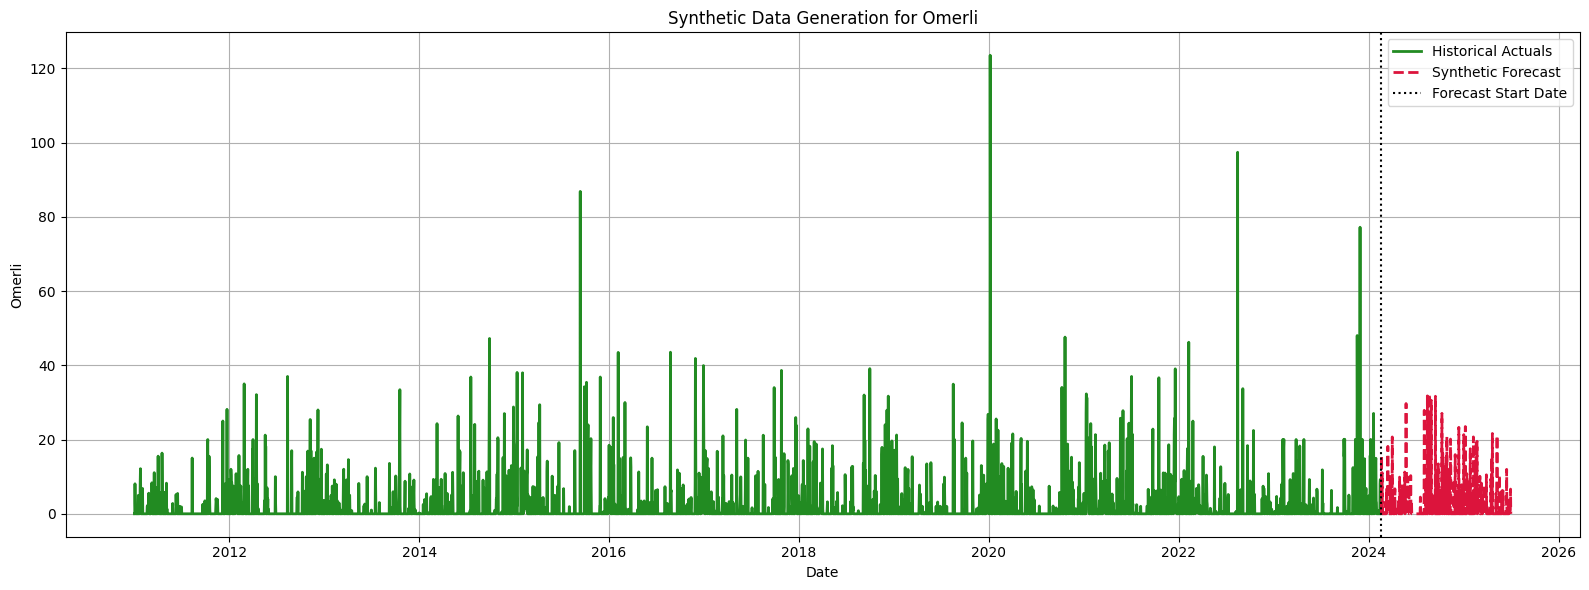

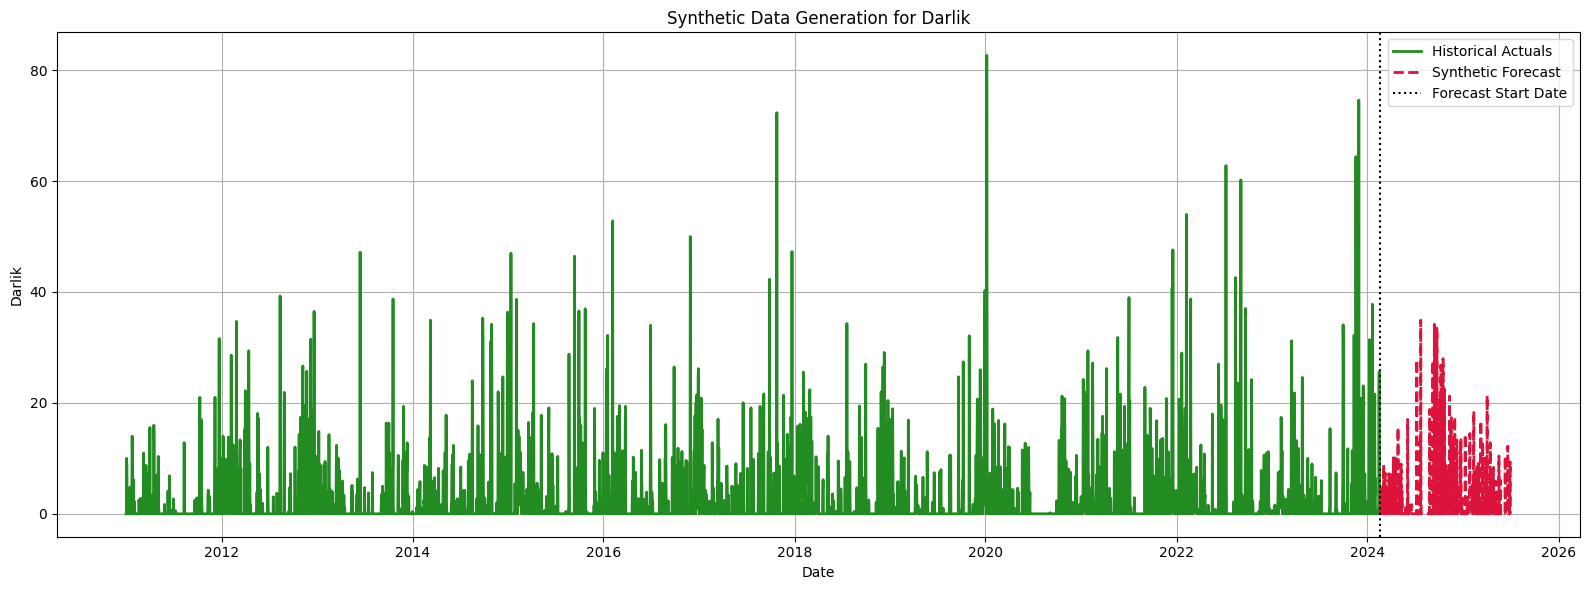

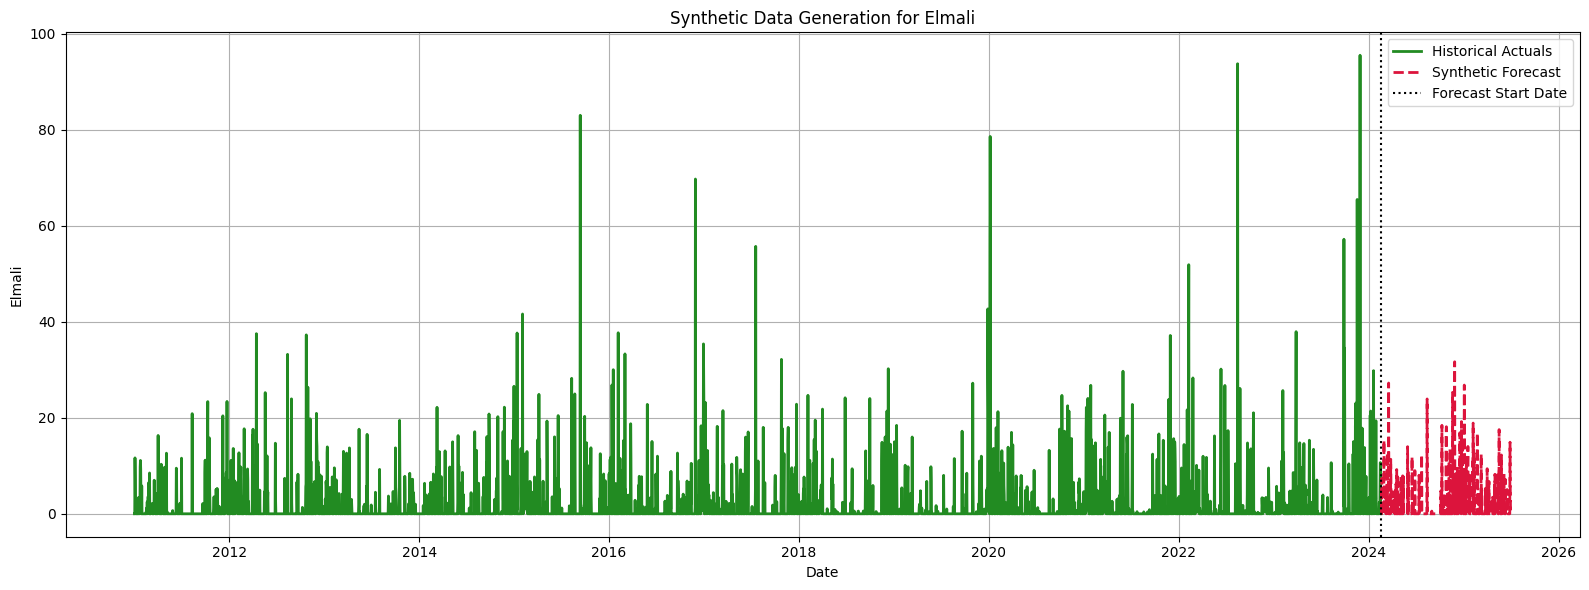


Final Rainfall/Consumption DataFrame starts on: 2011-01-01 00:00:00
Final Rainfall/Consumption DataFrame ends on: 2025-07-01 00:00:00
Final Rainfall/Consumption DataFrame shape: (5296, 12)

Synthetic rainfall/consumption data added and saved to: ../data/processed/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri_with_synthetic.csv


In [34]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

# --- 1. Veri Yükleme ve Temizleme ---
file_path_rainfall = "../data/raw/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri.xlsx"
df_rainfall = pd.read_excel(file_path_rainfall)

df_rainfall['Tarih'] = pd.to_datetime(df_rainfall['Tarih'], dayfirst=True)

# Unnamed sütunları burada temizle
df_rainfall = df_rainfall.loc[:, ~df_rainfall.columns.str.contains('^Unnamed')]

# Sütun adlarını standardize edelim (daha önce olduğu gibi)
renamed_cols_rainfall = {}
for col in df_rainfall.columns:
    new_name = (col.replace("Ö", "O").replace("ö", "o")
                         .replace("Ü", "U").replace("ü", "u")
                         .replace("Ş", "S").replace("ş", "s")
                         .replace("İ", "I").replace("ı", "i")
                         .replace("Ç", "C").replace("ç", "c")
                         .replace("Ğ", "G").replace("ğ", "g"))
    renamed_cols_rainfall[col] = new_name
df_rainfall.rename(columns=renamed_cols_rainfall, inplace=True)
df_rainfall.rename(columns={"Istanbul gunluk tuketim(m³/gun)": "Istanbul_Daily_Consumption"}, inplace=True)
df_rainfall.rename(columns={"B.cekmece": "Buyukcekmece"}, inplace=True)
df_rainfall.rename(columns={"istirancalar": "Istrancalar"}, inplace=True)

df_rainfall = df_rainfall.set_index('Tarih')

# Eksik değerleri temizle (ffill veya interpolate)
df_rainfall.ffill(inplace=True)
df_rainfall.bfill(inplace=True)

# Prophet'e verilecek sütunları daha güvenli seç
cols_to_process = []
for col in df_rainfall.columns:
    if pd.api.types.is_numeric_dtype(df_rainfall[col]):
        if df_rainfall[col].count() >= 2:
            cols_to_process.append(col)
        else:
            print(f"  - Skipping column '{col}' due to insufficient non-NaN data.")
    else:
        print(f"  - Skipping non-numeric column: '{col}'.")


# Hedef bitiş tarihi
end_date_forecast = pd.to_datetime('2025-07-01')

print(f"Original rainfall data ends on: {df_rainfall.index.max()}")
print(f"Target forecast end date: {end_date_forecast}")

# Kaç gün tahmin edeceğimizi hesapla
forecast_periods_rainfall = (end_date_forecast - df_rainfall.index.max()).days + 1

print(f"Number of days to forecast rainfall/consumption: {forecast_periods_rainfall}")

# Sentetik verileri depolamak için bir DataFrame
synthetic_rainfall_df = pd.DataFrame(index=pd.date_range(df_rainfall.index.max() + pd.Timedelta(days=1), end_date_forecast))

# --- 2. Prophet ile Tüketim Verisi Oluşturma (Bu kısım iyi çalıştığı için korundu) ---
print("\nGenerating synthetic consumption data using Prophet...")
consumption_col_name = 'Istanbul_Daily_Consumption'
if consumption_col_name in cols_to_process:
    series_prophet = df_rainfall[[consumption_col_name]].reset_index()
    series_prophet.columns = ['ds', 'y']
    
    model_consumption = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_consumption.fit(series_prophet)
    
    future = model_consumption.make_future_dataframe(periods=forecast_periods_rainfall)
    forecast_consumption = model_consumption.predict(future)
    
    synthetic_consumption_series = forecast_consumption[['ds', 'yhat']].set_index('ds')['yhat'].loc[synthetic_rainfall_df.index]
    synthetic_consumption_series[synthetic_consumption_series < 0] = 0 
    synthetic_rainfall_df[consumption_col_name] = synthetic_consumption_series
    print(f"  - Consumption data generated successfully.")
    # Plot consumption data
    plt.figure(figsize=(16, 6))
    plt.plot(df_rainfall.index, df_rainfall[consumption_col_name], label='Historical Actuals', color='forestgreen', linewidth=2)
    plt.plot(synthetic_rainfall_df.index, synthetic_rainfall_df[consumption_col_name], label='Synthetic Forecast', color='crimson', linestyle='--', linewidth=2)
    plt.axvline(df_rainfall.index.max(), color='black', linestyle=':', linewidth=1.5, label='Forecast Start Date')
    plt.title(f"Synthetic Data Generation for {consumption_col_name}")
    plt.xlabel("Date")
    plt.ylabel(consumption_col_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"  - {consumption_col_name} not found or insufficient data, skipping consumption forecast.")
    
# --- 3. Yağış Verileri İçin Sentetik Üretim (İyileştirilmiş Yöntem) ---
print("\nGenerating synthetic rainfall data (improved method)...")

# Yağış sütunlarını ayır
rainfall_cols = [col for col in cols_to_process if col != consumption_col_name]

# Her ay için yağışlı günlerin ortalamasını ve standart sapmasını hesapla
# Ayrıca, her ay için yağışlı günlerin oranını hesaplayalım
monthly_rainfall_stats = {}
for month in range(1, 13):
    monthly_data = df_rainfall[df_rainfall.index.month == month]
    
    # Sadece yağışlı günleri al (bir eşik belirleyebiliriz, örneğin > 0.1 mm)
    # Yağışlı günlerin oranını ve yağışlı günlerdeki ortalama/std'yi hesapla
    
    for r_col in rainfall_cols:
        # Eğer sütun NaN ise atla
        if r_col not in monthly_data.columns or monthly_data[r_col].isnull().all():
            continue

        wet_days = monthly_data[monthly_data[r_col] > 0] # > 0 olan günler yağışlı kabul edildi
        
        if len(wet_days) > 1: # En az 2 yağışlı gün olmalı ki std hesaplanabilsin
            monthly_rainfall_stats[(month, r_col)] = {
                'wet_day_ratio': len(wet_days) / len(monthly_data),
                'mean': wet_days[r_col].mean(),
                'std': wet_days[r_col].std() if wet_days[r_col].std() > 0 else wet_days[r_col].mean() * 0.1, # Eğer std 0 ise küçük bir değer atayalım
                'max': wet_days[r_col].max() # Max değeri de tutalım, pikleri sınırlamak için
            }
        elif len(wet_days) == 1: # Sadece 1 yağışlı gün varsa std 0 olur, ortalamayı al
             monthly_rainfall_stats[(month, r_col)] = {
                'wet_day_ratio': len(wet_days) / len(monthly_data),
                'mean': wet_days[r_col].mean(),
                'std': wet_days[r_col].mean() * 0.1 if wet_days[r_col].mean() * 0.1 > 0 else 0.1, # Küçük bir std atayalım
                'max': wet_days[r_col].max()
            }
        else: # Hiç yağışlı gün yoksa
            monthly_rainfall_stats[(month, r_col)] = {
                'wet_day_ratio': 0,
                'mean': 0,
                'std': 0,
                'max': 0
            }


for forecast_date in synthetic_rainfall_df.index:
    current_month = forecast_date.month
    
    for r_col in rainfall_cols:
        stats = monthly_rainfall_stats.get((current_month, r_col))
        
        if stats is None or stats['wet_day_ratio'] == 0:
            synthetic_rainfall_df.loc[forecast_date, r_col] = 0
            continue
            
        # Yağışlı gün mü olacak? Orana göre rastgele karar ver
        if np.random.rand() < stats['wet_day_ratio']:
            # Yağış miktarı: normal dağılımdan örnekle, negatif olmasın ve max değeri geçmesin
            sampled_rainfall = np.random.normal(stats['mean'], stats['std'])
            
            # Negatif yağış olamaz
            sampled_rainfall = max(0, sampled_rainfall)
            
            # Çok ekstrem değerleri sınırlamak için bir üst sınır (örn. geçmişteki aylık max değer)
            # Bu, aşırı büyük piklerin oluşmasını engeller, ancak yine de tamamen gerçekçi olmaz.
            sampled_rainfall = min(sampled_rainfall, stats['max'] * 1.5) # Geçmiş ayın max'ının 1.5 katını geçmesin

            synthetic_rainfall_df.loc[forecast_date, r_col] = sampled_rainfall
        else:
            synthetic_rainfall_df.loc[forecast_date, r_col] = 0

# Plot sample rainfall data
print("\n--- Plotting Synthetic Rainfall Data Generation Results (Sample Columns) ---")
for col_to_plot in rainfall_cols[:3]: # İlk 3 yağış sütununu çiz
    plt.figure(figsize=(16, 6))
    plt.plot(df_rainfall.index, df_rainfall[col_to_plot], label='Historical Actuals', color='forestgreen', linewidth=2)
    plt.plot(synthetic_rainfall_df.index, synthetic_rainfall_df[col_to_plot], label='Synthetic Forecast', color='crimson', linestyle='--', linewidth=2)
    plt.axvline(df_rainfall.index.max(), color='black', linestyle=':', linewidth=1.5, label='Forecast Start Date')
    plt.title(f"Synthetic Data Generation for {col_to_plot}")
    plt.xlabel("Date")
    plt.ylabel(col_to_plot)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- 4. Orijinal Veri ile Sentetik Veriyi Birleştirme (Final) ---
final_rainfall_df = pd.concat([df_rainfall, synthetic_rainfall_df])

final_rainfall_df = final_rainfall_df.sort_index().reset_index()
final_rainfall_df.rename(columns={'index': 'Tarih'}, inplace=True)

print(f"\nFinal Rainfall/Consumption DataFrame starts on: {final_rainfall_df['Tarih'].min()}")
print(f"Final Rainfall/Consumption DataFrame ends on: {final_rainfall_df['Tarih'].max()}")
print(f"Final Rainfall/Consumption DataFrame shape: {final_rainfall_df.shape}")

# --- 5. Yeni Veri Setini Kaydetme ---
output_file_path_rainfall = "../data/processed/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri_with_synthetic.csv"
final_rainfall_df.to_csv(output_file_path_rainfall, index=False)
print(f"\nSynthetic rainfall/consumption data added and saved to: {output_file_path_rainfall}")



## Correlation Controls

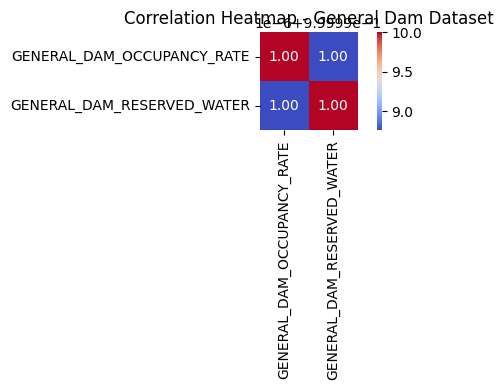

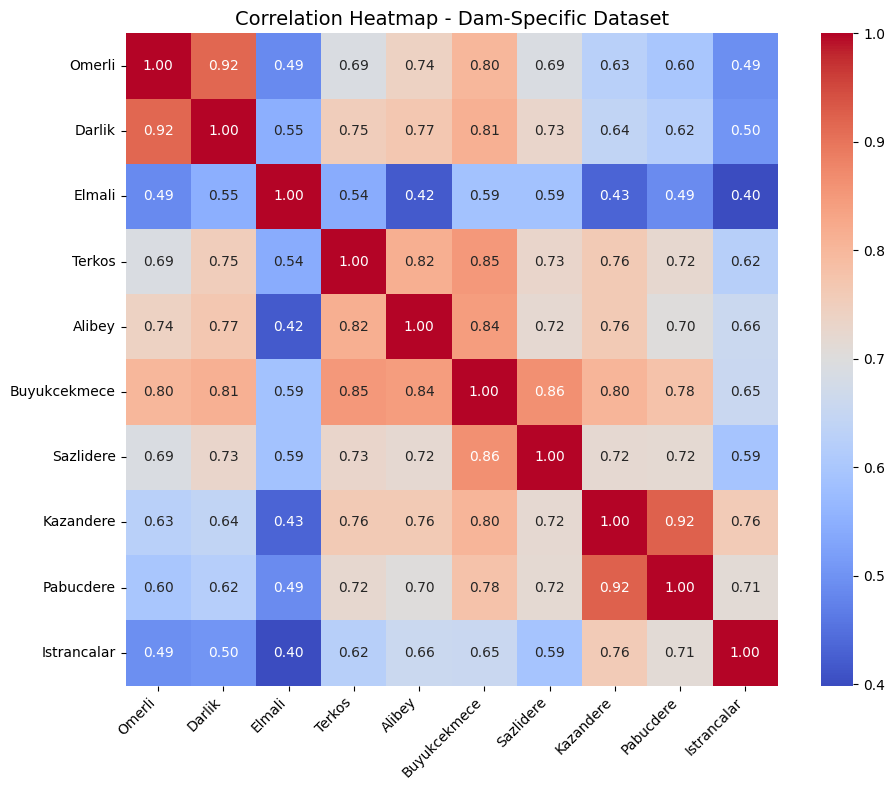

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
#  Correlation for General Dataset
# ==============================

# Loading cleaned general dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Correlation matrix for numerical columns
plt.figure(figsize=(6, 4))
sns.heatmap(df_general.drop(columns='DATE').corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - General Dam Dataset", fontsize=12)
plt.tight_layout()
plt.show()


# ==============================
#  Correlation for Dam-Specific Dataset
# ==============================

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Compute correlation matrix (excluding date)
correlation_matrix = df_dams.drop(columns='Tarih').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - Dam-Specific Dataset", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Merging and Preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# --- 1. Bölüm: Genel Baraj Veri Seti Birleştirme (Değişiklik Yok) ---
# (Bu bölüm önceki kodunuzla aynıdır ve sorun bu kısımda değil.)

# Loading cleaned general dam dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Loading rainfall and consumption dataset
df_rainfall = pd.read_excel("../data/processed/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri_with_synthetic.csv")
df_rainfall['Tarih'] = pd.to_datetime(df_rainfall['Tarih'])

# Standardizing column names for merging
df_rainfall.rename(columns={'Tarih': 'DATE'}, inplace=True)

# Merging datasets on DATE
merged_general = pd.merge(df_general, df_rainfall, on='DATE', how='inner')
merged_general = merged_general.loc[:, ~merged_general.columns.str.contains('^Unnamed')]

# Handling outliers using IQR method
Q1 = merged_general.drop(columns='DATE').quantile(0.25)
Q3 = merged_general.drop(columns='DATE').quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_general.update(merged_general.drop(columns='DATE').clip(lower=lower_bound, upper=upper_bound, axis=1))

# Checking for null values
print("\nMissing values in merged general dam dataset:")
print(merged_general.isnull().sum())

# Filling missing values with linear interpolation
merged_general.interpolate(method='linear', inplace=True)

# Sorting and resetting index
merged_general.sort_values('DATE', inplace=True)
merged_general.reset_index(drop=True, inplace=True)

# Renaming the water consumption column to English
merged_general.rename(columns={"İstanbul günlük tüketim(m³/gün)": "Istanbul_Daily_Consumption"}, inplace=True)

# Renaming columns to standardized English format
renamed_columns_general = {} # Farklı bir dict adı kullanıldı
for col in merged_general.columns:
    if "_x" in col:
        new_name = col.replace("_x", "_Fill")
    elif "_y" in col:
        new_name = col.replace("_y", "_Rainfall")
    else:
        new_name = col
    new_name = (new_name.replace("Ö", "O").replace("ö", "o")
                         .replace("Ü", "U").replace("ü", "u")
                         .replace("Ş", "S").replace("ş", "s")
                         .replace("İ", "I").replace("ı", "i")
                         .replace("Ç", "C").replace("ç", "c")
                         .replace("Ğ", "G").replace("ğ", "g"))
    renamed_columns_general[col] = new_name

merged_general.rename(columns=renamed_columns_general, inplace=True)

# Saving the merged dataset
merged_general.to_csv("../data/processed/merged_general_dam.csv", index=False)
print("\nSaved: ../data/processed/merged_general_dam.csv")


# --- 2. Bölüm: Baraja Özel Veri Seti Birleştirme (Değişiklik Yapılan Kısım) ---

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned_with_synthetic.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Standardizing for merging
df_rainfall_specific = pd.read_excel("../data/raw/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri.xlsx")
df_rainfall_specific['Tarih'] = pd.to_datetime(df_rainfall_specific['Tarih'])


# --- BURADA ÖNEMLİ DEĞİŞİKLİKLER VAR ---

# 1. Yağış verisindeki baraj isimlerini doluluk verisiyle eşleştirme
# df_dams'taki baraj kolonları (Tarih hariç)
dam_occupancy_cols = df_dams.columns.drop('Tarih').tolist()

# df_rainfall_specific'teki baraj kolonlarını standartlaştır
# Türkçe karakterleri İngilizce'ye çevir ve isimleri uyumlu hale getir
# Özellikle B.çekmece -> Buyukcekmece, ıstırancalar -> Istrancalar gibi
rainfall_rename_map = {
    'Ömerli': 'Omerli',
    'Darlik': 'Darlik',
    'Elmali': 'Elmali',
    'Terkos': 'Terkos',
    'B.çekmece': 'Buyukcekmece', # Önemli değişiklik
    'Sazlidere': 'Sazlidere',
    'Alibey': 'Alibey',
    'Kazandere': 'Kazandere',
    'Pabuçdere': 'Pabucdere',
    'ıstırancalar': 'Istrancalar', # Önemli değişiklik
    # Diğer sütun adlarını da buraya ekleyebilirsiniz, örneğin 'İstanbul günlük tüketim(m³/gün)'
    "İstanbul günlük tüketim(m³/gün)": "Istanbul_Daily_Consumption" # Bunu da önceden halledelim
}

# Yağış verisindeki baraj sütunlarını yeniden adlandır
# Sadece map'te olan sütunları etkilemek için intersection kontrolü yapabilirsiniz
cols_to_rename_rainfall = {k: v for k, v in rainfall_rename_map.items() if k in df_rainfall_specific.columns}
df_rainfall_specific.rename(columns=cols_to_rename_rainfall, inplace=True)

# Şimdi, sadece baraj isimleriyle çakışan sütunları bırakmak için df_rainfall_specific'i filtreleyelim.
# df_dams ve df_rainfall_specific'in ortak baraj sütunlarını bulalım
common_dams = list(set(dam_occupancy_cols) & set(df_rainfall_specific.columns))
# Tarih ve Istanbul_Daily_Consumption'ı da dahil et
cols_for_rainfall_merge = ['Tarih', 'Istanbul_Daily_Consumption'] + common_dams

# Sadece gerekli sütunları seçin, böylece gereksiz kopyalar veya farklı adlandırmalar merge'e girmez
df_rainfall_specific_filtered = df_rainfall_specific[cols_for_rainfall_merge]


# Merging on Tarih
# suffixes parametresi ile _x ve _y soneklerinin ne olacağını baştan belirleyebiliriz.
merged_dam_specific = pd.merge(
    df_dams,
    df_rainfall_specific_filtered, # Filtrelenmiş df_rainfall_specific kullanıldı
    on='Tarih',
    how='inner',
    suffixes=('_Fill', '_Rainfall') # Sonekleri doğrudan burada belirle
)

# Unnamed sütunlarını temizle
merged_dam_specific = merged_dam_specific.loc[:, ~merged_dam_specific.columns.str.contains('^Unnamed')]

# --- Aykırı değer, null değer, sıralama kısmı aynı ---
# Handling outliers using IQR method
Q1_dams = merged_dam_specific.drop(columns='Tarih').quantile(0.25)
Q3_dams = merged_dam_specific.drop(columns='Tarih').quantile(0.75)
IQR_dams = Q3_dams - Q1_dams
lower_bound_dams = Q1_dams - 1.5 * IQR_dams
upper_bound_dams = Q3_dams + 1.5 * IQR_dams

merged_dam_specific.update(
    merged_dam_specific.drop(columns='Tarih').clip(lower=lower_bound_dams, upper=upper_bound_dams, axis=1)
)

# Null check
print("\nMissing values in merged dam-specific dataset:")
print(merged_dam_specific.isnull().sum())

# Interpolation to handle any remaining missing values
merged_dam_specific.interpolate(method='linear', inplace=True)

# Sorting and resetting index
merged_dam_specific.sort_values('Tarih', inplace=True)
merged_dam_specific.reset_index(drop=True, inplace=True)

# --- Yeniden adlandırma kısmı basitleşti çünkü suffixes kullanıldı ve Türkçe karakterler önceden halledildi ---

# Sadece Türkçe karakter dönüşümü yapıldı, _x/_y artık yok
final_renamed_cols = {}
for col in merged_dam_specific.columns:
    new_name = (col.replace("Ö", "O").replace("ö", "o")
                       .replace("Ü", "U").replace("ü", "u")
                       .replace("Ş", "S").replace("ş", "s")
                       .replace("İ", "I").replace("ı", "i")
                       .replace("Ç", "C").replace("ç", "c")
                       .replace("Ğ", "G").replace("ğ", "g"))
    final_renamed_cols[col] = new_name

merged_dam_specific.rename(columns=final_renamed_cols, inplace=True)


# Saving the final merged dataset
merged_dam_specific.to_csv("../data/processed/merged_dam_specific.csv", index=False)
print("\nSaved: ../data/processed/merged_dam_specific.csv")
print(merged_dam_specific.head())

ValueError: Excel file format cannot be determined, you must specify an engine manually.

## EDA and Outlier Analysis for Merged General Dam Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750 entries, 0 to 3749
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DATE                        3750 non-null   datetime64[ns]
 1   GENERAL_DAM_OCCUPANCY_RATE  3750 non-null   float64       
 2   GENERAL_DAM_RESERVED_WATER  3750 non-null   float64       
 3   Omerli                      3750 non-null   float64       
 4   Darlik                      3750 non-null   float64       
 5   Elmali                      3750 non-null   float64       
 6   Terkos                      3750 non-null   float64       
 7   B.cekmece                   3750 non-null   float64       
 8   Sazlidere                   3750 non-null   float64       
 9   Alibey                      3750 non-null   float64       
 10  Kazandere                   3750 non-null   float64       
 11  Pabucdere                   3750 non-null   float64     

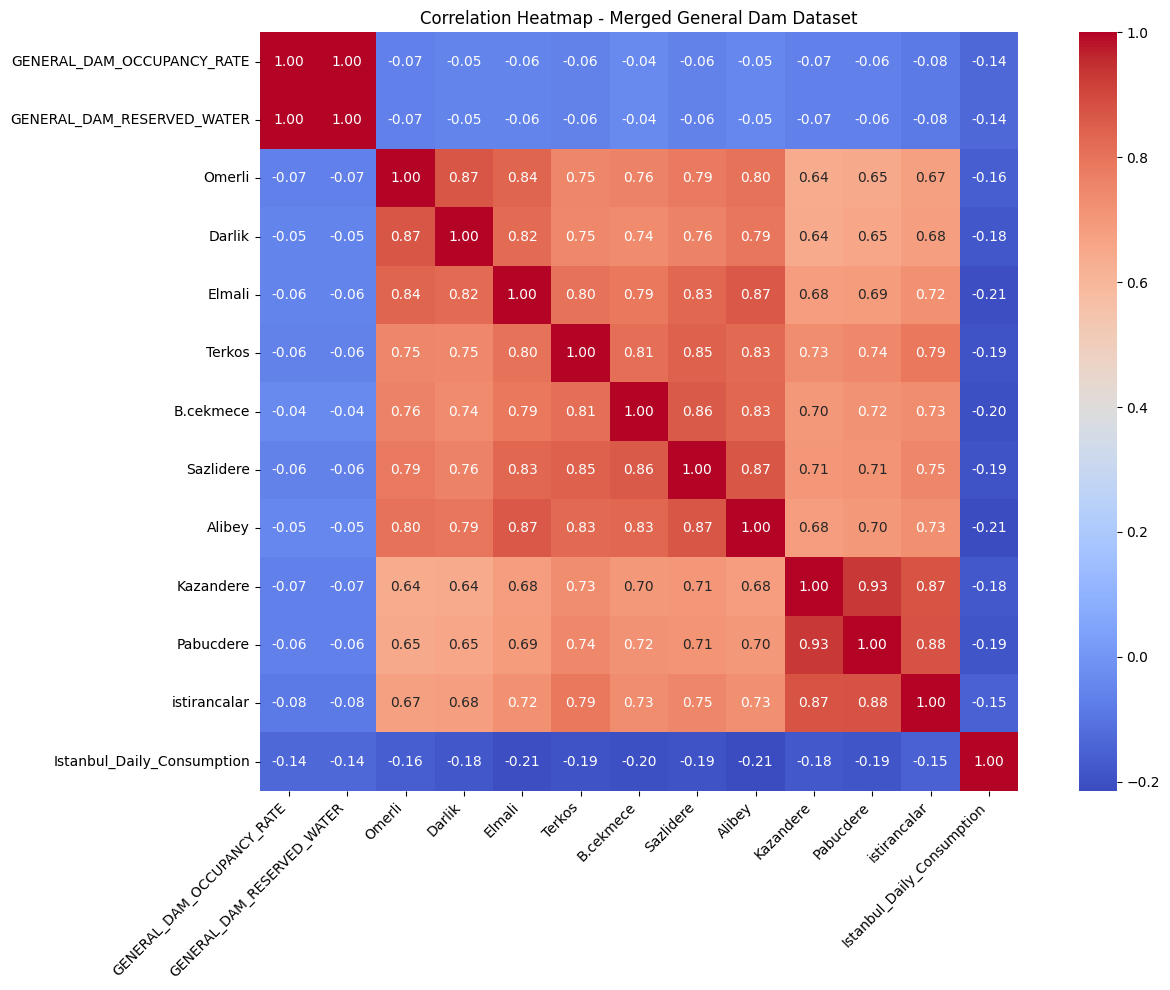

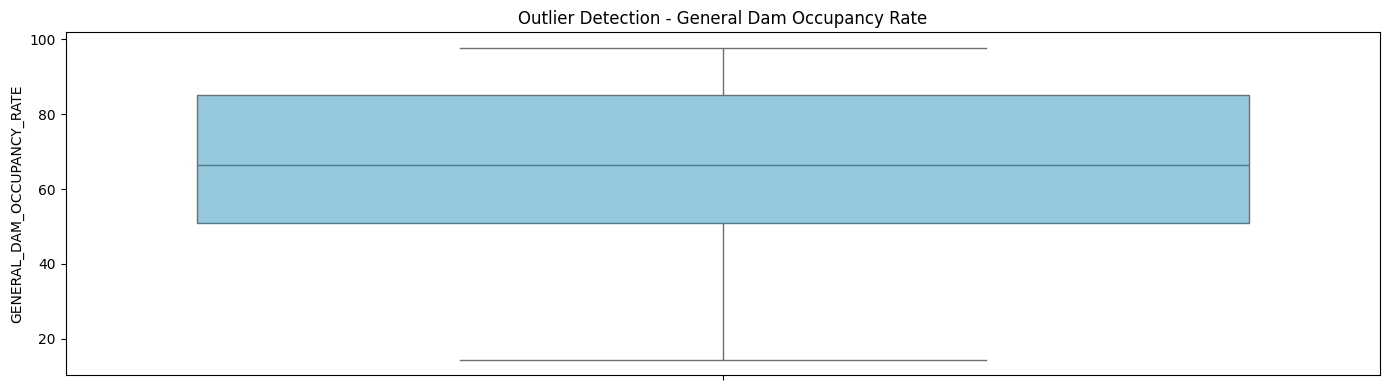

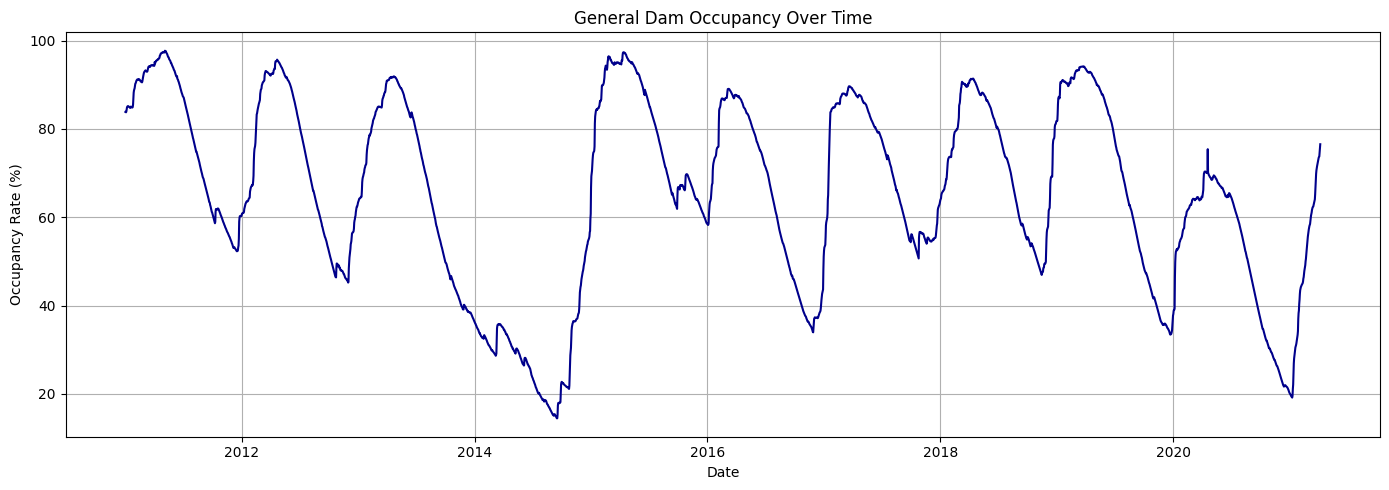

In [19]:
# Loading merged general dam dataset
df_general = pd.read_csv("../data/processed/merged_general_dam.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Displaying general structure
print(df_general.info())
print(df_general.describe())

# Checking missing values
missing_values = df_general.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(df_general.drop(columns=["DATE"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - Merged General Dam Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Outlier detection via boxplots
plt.figure(figsize=(14, 4))
sns.boxplot(data=df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='skyblue')
plt.title("Outlier Detection - General Dam Occupancy Rate")
plt.tight_layout()
plt.show()

# Trend line for general dam occupancy
plt.figure(figsize=(14, 5))
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], label='Occupancy Rate', color='darkblue')
plt.title("General Dam Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## EDA and Outlier Analysis for Merged Dam-Specific Dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Tarih                       4797 non-null   datetime64[ns]
 1   Omerli_Fill                 4797 non-null   float64       
 2   Darlik_Fill                 4797 non-null   float64       
 3   Elmali_Fill                 4797 non-null   float64       
 4   Terkos_Fill                 4797 non-null   float64       
 5   Alibey_Fill                 4797 non-null   float64       
 6   Buyukcekmece_Fill           4797 non-null   float64       
 7   Sazlidere_Fill              4797 non-null   float64       
 8   Kazandere_Fill              4797 non-null   float64       
 9   Pabucdere_Fill              4797 non-null   float64       
 10  Istrancalar_Fill            4797 non-null   float64       
 11  Istanbul_Daily_Consumption  4797 non-null   float64     

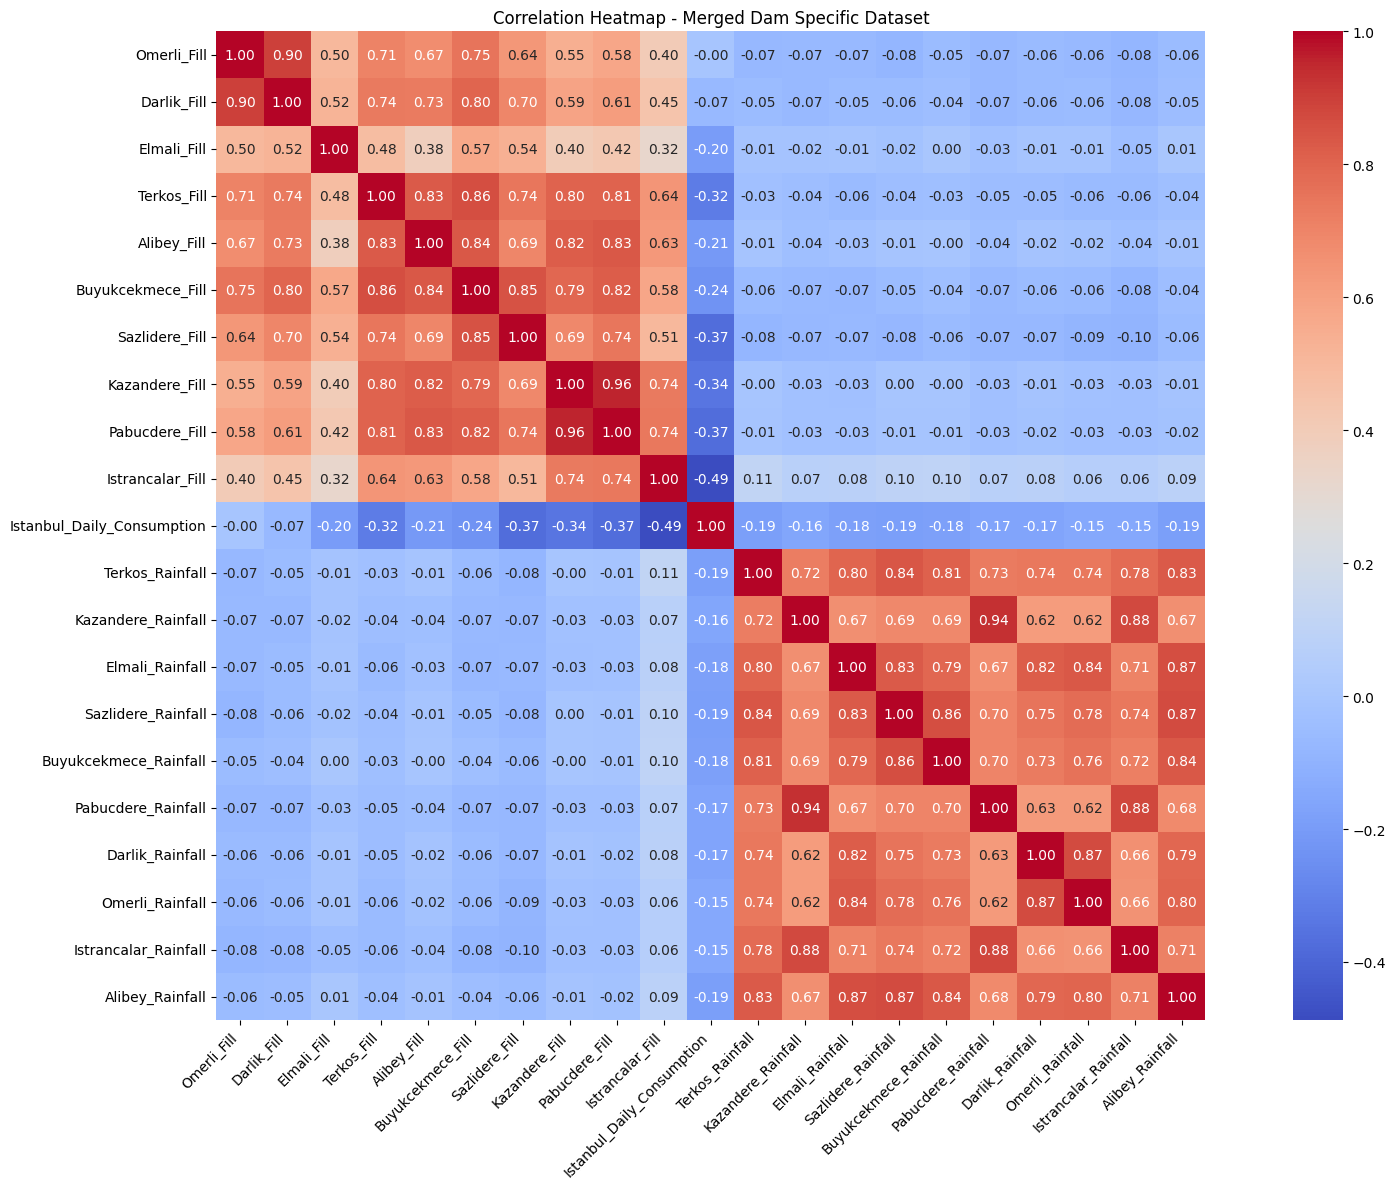

KeyError: 'Ömerli'

<Figure size 1000x400 with 0 Axes>

In [20]:
# Loading merged dam-specific dataset
df_specific = pd.read_csv("../data/processed/merged_dam_specific.csv")
df_specific['Tarih'] = pd.to_datetime(df_specific['Tarih'])

# Displaying general structure
print(df_specific.info())
print(df_specific.describe())

# Checking missing values
missing_values = df_specific.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Correlation heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(df_specific.drop(columns=["Tarih"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - Merged Dam Specific Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Outlier detection - Ömerli as example
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_specific['Ömerli'], color='salmon')
plt.title("Outlier Detection - Ömerli Dam")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='steelblue', linewidth=1.8)
plt.title("General Dam Occupancy Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()








## General Dam Occupancy + Water Consumption Plot

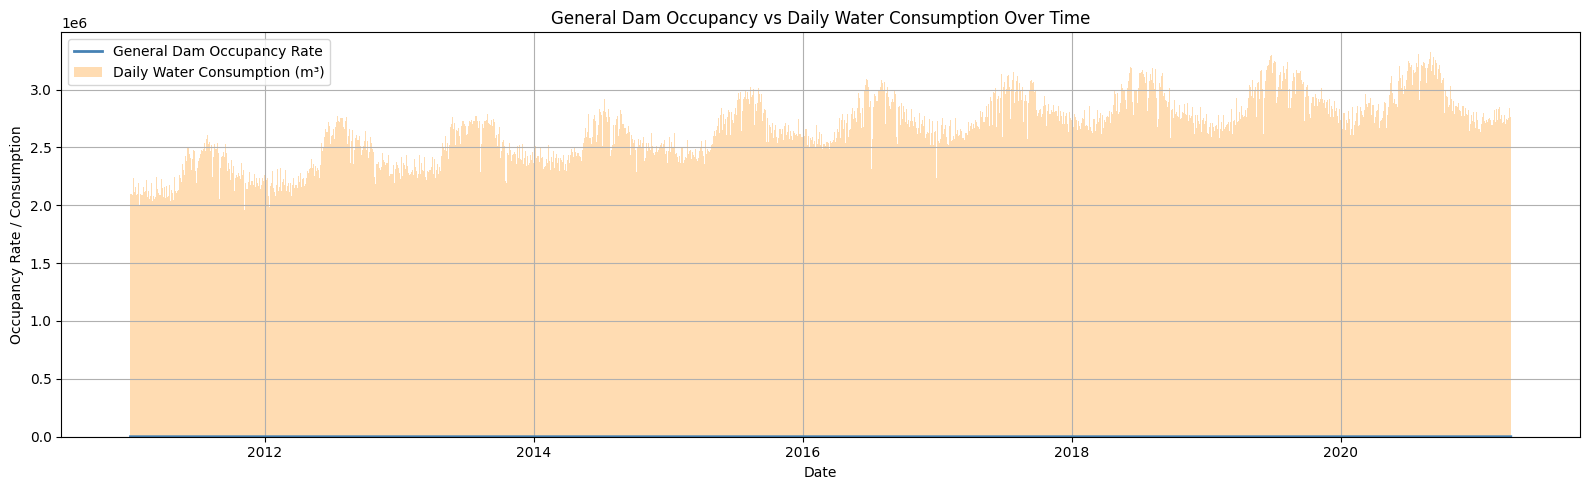

In [ ]:
# Loading merged general dam dataset
df_general = pd.read_csv("../data/processed/merged_general_dam.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])
df_general.sort_values('DATE', inplace=True)

plt.figure(figsize=(16, 5))

# Plotting dam occupancy rate
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='steelblue',
         linewidth=2, label='General Dam Occupancy Rate')

# Plotting daily water consumption as vertical bars
plt.bar(df_general['DATE'], df_general['Istanbul_Daily_Consumption'], width=1.0, alpha=0.3,
        color='darkorange', label='Daily Water Consumption (m³)')

plt.title("General Dam Occupancy vs Daily Water Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate / Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Dam-Specific Occupancy + Water Consumption

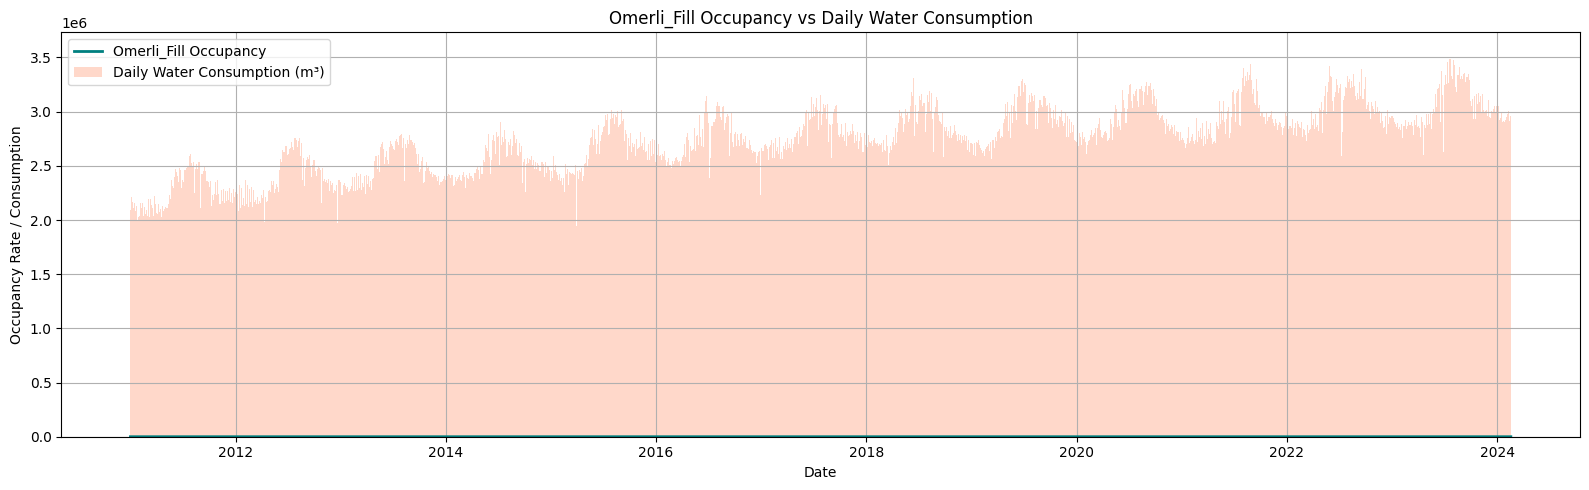

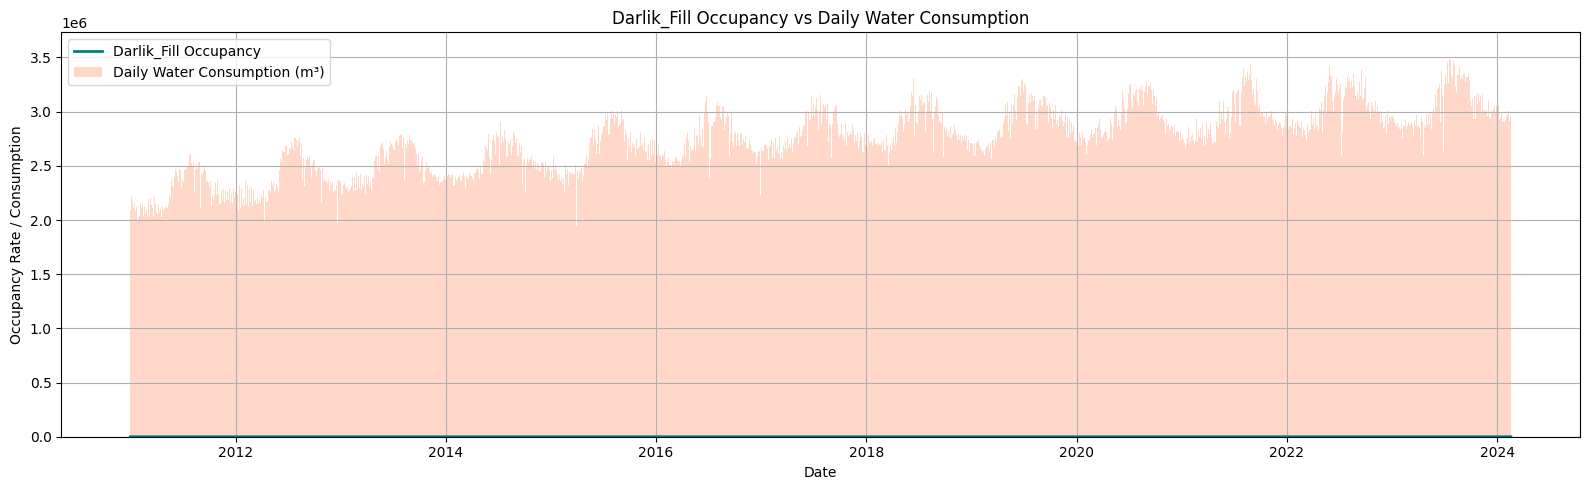

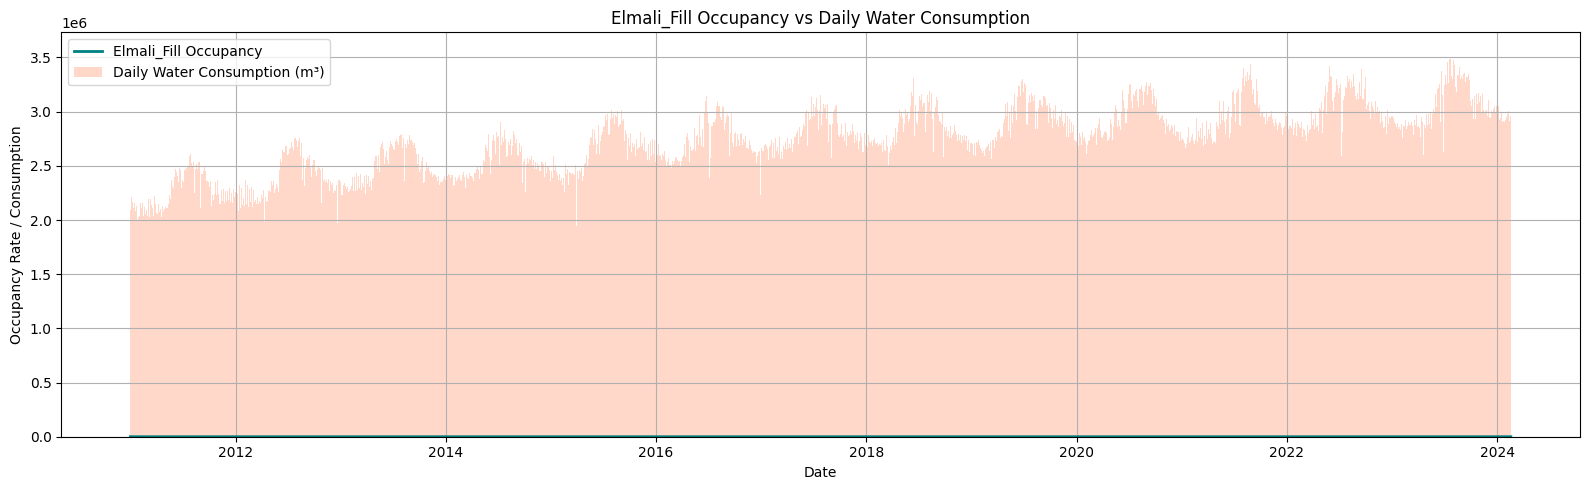

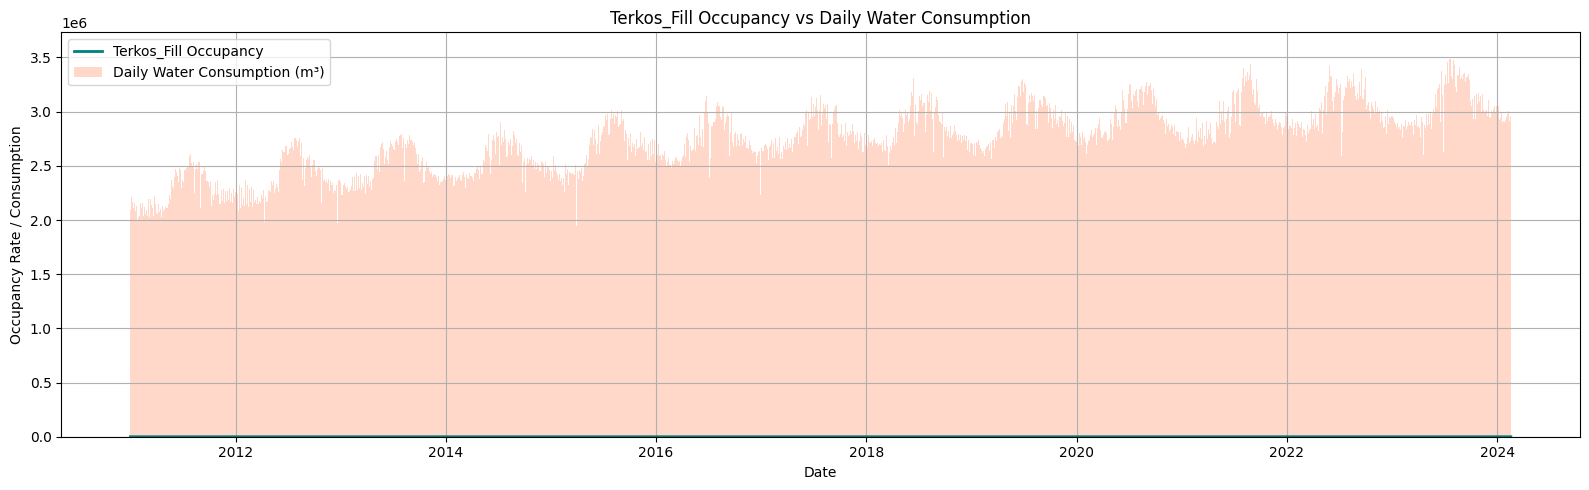

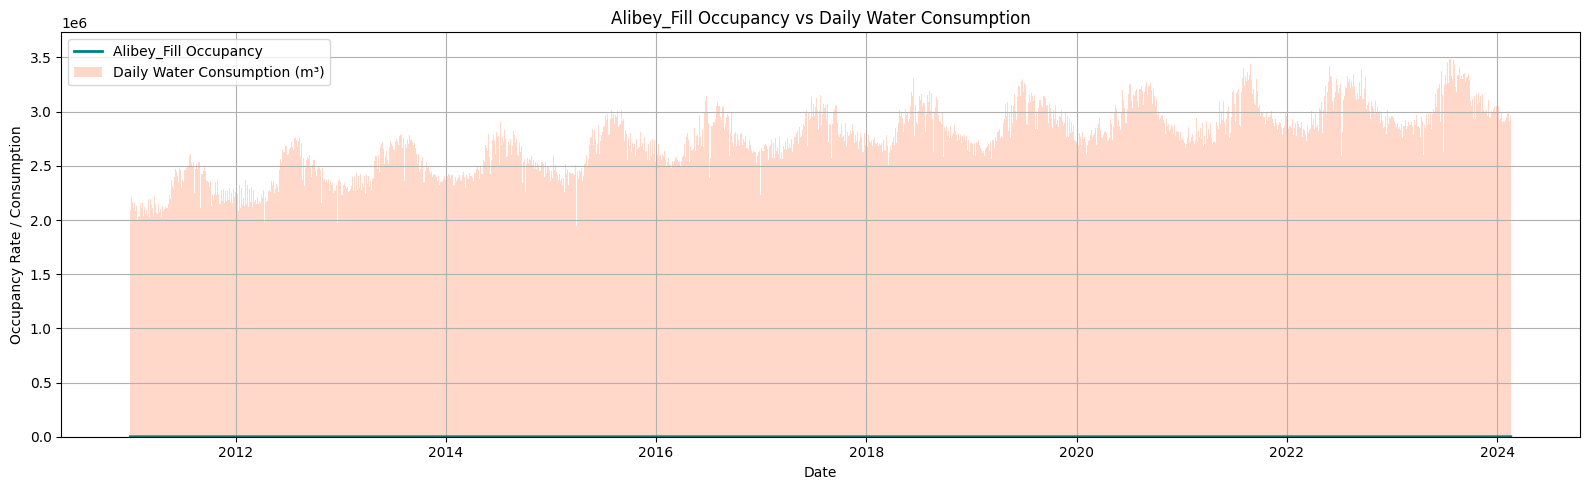

KeyboardInterrupt: 

In [ ]:
# Loading merged dam-specific dataset
df_dams = pd.read_csv("../data/processed/merged_dam_specific.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])
df_dams.sort_values('Tarih', inplace=True)

# Getting dam names (excluding Tarih and consumption columns)
dam_columns = [col for col in df_dams.columns if col not in ['Tarih', 'GÜNLÜK SU TÜKETİMİ (m³)', 'TOPLAM YAĞIŞ (mm)']]

for dam in dam_columns:
    plt.figure(figsize=(16, 5))
    
    # Plotting dam occupancy
    plt.plot(df_dams['Tarih'], df_dams[dam], label=f'{dam} Occupancy', color='teal', linewidth=2)

    # Plotting water consumption
    plt.bar(df_dams['Tarih'], df_dams['Istanbul_Daily_Consumption'], width=1.0, alpha=0.3,
            color='coral', label='Daily Water Consumption (m³)')

    plt.title(f"{dam} Occupancy vs Daily Water Consumption")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate / Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
